# 01. Market Expectations In The Cross-Section Of Present Values

## Imports

In [1]:
import numpy as np
import pandas as pd
import sys

from matplotlib import pyplot as plt
from settings import config
from pathlib import Path
import load_data
import regressions
import pull_CRSP_index
import pull_ken_french_data

# Load environment variables
DATA_DIR = Path(config("DATA_DIR"))
OUTPUT_DIR = Path(config("OUTPUT_DIR"))
WRDS_USERNAME = config("WRDS_USERNAME")
START_DATE = config("START_DATE")
END_DATE = config("END_DATE")

## Prep Data

### Step 1: Fama-French Data

In [2]:
from pandas_datareader.famafrench import get_available_datasets
import pandas_datareader.data as web

get_available_datasets()

['F-F_Research_Data_Factors',
 'F-F_Research_Data_Factors_weekly',
 'F-F_Research_Data_Factors_daily',
 'F-F_Research_Data_5_Factors_2x3',
 'F-F_Research_Data_5_Factors_2x3_daily',
 'Portfolios_Formed_on_ME',
 'Portfolios_Formed_on_ME_Wout_Div',
 'Portfolios_Formed_on_ME_Daily',
 'Portfolios_Formed_on_BE-ME',
 'Portfolios_Formed_on_BE-ME_Wout_Div',
 'Portfolios_Formed_on_BE-ME_Daily',
 'Portfolios_Formed_on_OP',
 'Portfolios_Formed_on_OP_Wout_Div',
 'Portfolios_Formed_on_OP_Daily',
 'Portfolios_Formed_on_INV',
 'Portfolios_Formed_on_INV_Wout_Div',
 'Portfolios_Formed_on_INV_Daily',
 '6_Portfolios_2x3',
 '6_Portfolios_2x3_Wout_Div',
 '6_Portfolios_2x3_weekly',
 '6_Portfolios_2x3_daily',
 '25_Portfolios_5x5',
 '25_Portfolios_5x5_Wout_Div',
 '25_Portfolios_5x5_Daily',
 '100_Portfolios_10x10',
 '100_Portfolios_10x10_Wout_Div',
 '100_Portfolios_10x10_Daily',
 '6_Portfolios_ME_OP_2x3',
 '6_Portfolios_ME_OP_2x3_Wout_Div',
 '6_Portfolios_ME_OP_2x3_daily',
 '25_Portfolios_ME_OP_5x5',
 '25_Portf

In [3]:
bm_6_portfolios = pull_ken_french_data.pull_ken_french_excel(dataset_name="6_Portfolios_2x3",
     data_dir=DATA_DIR,
     log=True,
     start_date=START_DATE,
     end_date=END_DATE)

bm_25_portfolios = pull_ken_french_data.pull_ken_french_excel(dataset_name="25_Portfolios_5x5",
     data_dir=DATA_DIR,
     log=True,
     start_date=START_DATE,
     end_date=END_DATE)

bm_100_portfolios = pull_ken_french_data.pull_ken_french_excel(
     dataset_name="100_Portfolios_10x10",
     data_dir=DATA_DIR,
     log=True,
     start_date=START_DATE,
     end_date=END_DATE)



Excel file saved to C:\Users\zacjo\OneDrive\Documents\GitHub\finm32900_project_group6\data\6_Portfolios_2x3.xlsx
Excel file saved to C:\Users\zacjo\OneDrive\Documents\GitHub\finm32900_project_group6\data\25_Portfolios_5x5.xlsx
Excel file saved to C:\Users\zacjo\OneDrive\Documents\GitHub\finm32900_project_group6\data\100_Portfolios_10x10.xlsx


In [4]:
bm_6_portfolios = load_data.load_ken_french()
bm_6_portfolios

,Date,SMALL LoBM,ME1 BM2,SMALL HiBM,BIG LoBM,ME2 BM2,BIG HiBM
0,1930-01-01,6.0455,9.5581,8.4631,7.1735,3.4044,2.8433
1,1930-02-01,1.7451,1.0483,4.3779,3.4639,1.9031,1.2229
2,1930-03-01,8.6368,11.3525,10.7647,6.8160,8.3584,5.3421
3,1930-04-01,-7.0717,-1.2287,-3.4814,-2.3610,-1.7133,-6.6589
4,1930-05-01,-3.6161,-2.4200,-2.9578,0.7061,-2.2640,-1.4054
...,...,...,...,...,...,...,...
968,2010-09-01,14.0514,12.7735,10.9568,10.0755,8.9842,6.8510
969,2010-10-01,4.4471,4.2271,3.6404,4.5444,3.8611,0.5078
970,2010-11-01,3.7207,4.1029,3.3312,0.5094,0.3779,-1.0253
971,2010-12-01,7.3154,8.3352,9.4636,4.9391,7.7950,10.1774


### Step 2: CRSP Market Capitalization Weighted Index Data

In [5]:
crsp = pull_CRSP_index.pull_crsp_value_weighted_index()

Loading library list...
Done
Approximately 1189 rows in crsp.msi.
CRSP.msi Table Columns: ['name', 'nullable', 'type', 'comment']
CRSP value-weighted index data saved to crsp_value_weighted_index.csv
CSV file saved to C:\Users\zacjo\OneDrive\Documents\GitHub\finm32900_project_group6\data\crsp_value_weighted_index.csv


In [6]:
crsp_loaded = load_data.load_crsp_index()
crsp_loaded

,date,value_weighted_return
0,1930-02-01,0.056765
1,1930-03-01,0.027851
2,1930-04-01,0.071977
3,1930-05-01,-0.020755
4,1930-06-01,-0.014109
...,...,...
967,2010-09-01,-0.043809
968,2010-10-01,0.087670
969,2010-11-01,0.037865
970,2010-12-01,0.005104


### Step 3: Excess Returns

In [7]:
ex_ret = load_data.load_and_compute_log_returns()
ex_ret

date
1930-02-01    0.056765
1930-03-01    0.027851
1930-04-01    0.071977
1930-05-01   -0.020755
1930-06-01   -0.014109
                ...   
2010-09-01   -0.043809
2010-10-01    0.087670
2010-11-01    0.037865
2010-12-01    0.005104
2011-01-01    0.065022
Name: value_weighted_return, Length: 972, dtype: float64

# Run Regressions

# Run Regressions for B/M ratios


Processing 100-Portfolios Data
Aligned data from 1930-02-01 to 2010-06-01
Number of dates: 965
Date range: 1930-02-01 to 1980-01-01
Number of dates: 600
Date range: 1930-02-01 to 1980-01-01
Number of dates: 600
First-Stage Estimated Loadings (phi_i):
SMALL LoBM: -4.0474
ME1 BM2: 46.8373
ME1 BM3: 55.6571
ME1 BM4: 48.3165
ME1 BM5: 3.5649
ME1 BM6: 17.4216
ME1 BM7: -0.7195
ME1 BM8: -0.8010
ME1 BM9: -0.8435
SMALL HiBM: -0.8855
ME2 BM1: 24.0797
ME2 BM2: -16.5666
ME2 BM3: 40.8811
ME2 BM4: -0.6035
ME2 BM5: -0.7443
ME2 BM6: -0.6813
ME2 BM7: -0.6709
ME2 BM8: -0.6055
ME2 BM9: -0.6622
ME2 BM10: -0.6390
ME3 BM1: 29.8218
ME3 BM2: 5.1879
ME3 BM3: 16.8336
ME3 BM4: -0.9340
ME3 BM5: -0.4937
ME3 BM6: -0.5955
ME3 BM7: -0.6938
ME3 BM8: -0.6266
ME3 BM9: -0.7063
ME3 BM10: -0.7067
ME4 BM1: 0.6917
ME4 BM2: -0.3365
ME4 BM3: -0.4393
ME4 BM4: -0.5150
ME4 BM5: -0.5922
ME4 BM6: -0.4809
ME4 BM7: -0.5080
ME4 BM8: -0.6265
ME4 BM9: -0.7220
ME4 BM10: -0.6212
ME5 BM1: 18.3979
ME5 BM2: -0.3823
ME5 BM3: -0.5187
ME5 BM4: -

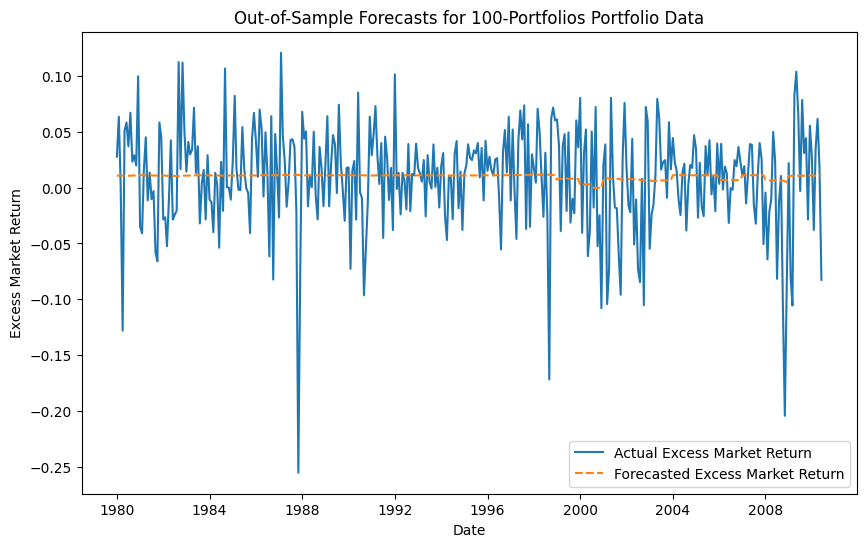

{'100-Portfolios': {'in_sample': {'phi': {'SMALL LoBM': -4.047413358254689,
    'ME1 BM2': 46.83730656362021,
    'ME1 BM3': 55.657059576491406,
    'ME1 BM4': 48.316482333259394,
    'ME1 BM5': 3.5649011137141335,
    'ME1 BM6': 17.421559481524937,
    'ME1 BM7': -0.7194909772227961,
    'ME1 BM8': -0.8009563650952575,
    'ME1 BM9': -0.8434729204045323,
    'SMALL HiBM': -0.8854992611266324,
    'ME2 BM1': 24.079697050256126,
    'ME2 BM2': -16.56655259269345,
    'ME2 BM3': 40.881149453325705,
    'ME2 BM4': -0.6034748885530073,
    'ME2 BM5': -0.7443204305930805,
    'ME2 BM6': -0.6813127908489385,
    'ME2 BM7': -0.6709153833482822,
    'ME2 BM8': -0.6054993218282368,
    'ME2 BM9': -0.6622249915326258,
    'ME2 BM10': -0.6390190626265829,
    'ME3 BM1': 29.821773485676488,
    'ME3 BM2': 5.1878852061483265,
    'ME3 BM3': 16.833552783433753,
    'ME3 BM4': -0.9340466092658466,
    'ME3 BM5': -0.4936632556135828,
    'ME3 BM6': -0.595451193384381,
    'ME3 BM7': -0.693812714340576

In [8]:
def regress():
    portfolio_datasets = {
        # "6-Portfolios": "6_Portfolios_2x3",
        # "25-Portfolios": "25_Portfolios_5x5",
        "100-Portfolios": "100_Portfolios_10x10"
    }
    results = {}
    for label, dataset_name in portfolio_datasets.items():
        print(f"\nProcessing {label} Data")
        in_sample = regressions.run_in_sample_pls(
            dataset_name=dataset_name, 
            weighting="BE_FYt-1_to_ME_June_t", 
            h=1, 
            end_date='1980-01-01')
        recursive = regressions.run_recursive_forecast(
            dataset_name=dataset_name, 
            weighting="BE_FYt-1_to_ME_June_t", 
            h=1, 
            start_train_date='1930-01-01', 
            end_train_date='1980-01-01',
            end_forecast_date='2011-01-01')
        regressions.display_results(label, in_sample, recursive)
        results[label] = {"in_sample": in_sample, "recursive": recursive}
    return results

regress()


[Annual] Processing 100-Portfolios Data
[Annual In-Sample] Data from 1931-01-01 to 1980-01-01 (n = 50)
Annual First-Stage Estimated Loadings (phi_i):
SMALL LoBM: -2.9577
ME1 BM2: 50.5068
ME1 BM3: -26.0547
ME1 BM4: 8.8005
ME1 BM5: 49.1863
ME1 BM6: 1.4029
ME1 BM7: 0.6583
ME1 BM8: 0.8978
ME1 BM9: 0.7128
SMALL HiBM: 0.6490
ME2 BM1: -40.4248
ME2 BM2: 32.0012
ME2 BM3: -16.1311
ME2 BM4: 0.5904
ME2 BM5: 0.8272
ME2 BM6: 0.7322
ME2 BM7: 0.7901
ME2 BM8: 0.7114
ME2 BM9: 0.6044
ME2 BM10: 0.6923
ME3 BM1: 3.4538
ME3 BM2: -9.4273
ME3 BM3: -20.8904
ME3 BM4: 1.4620
ME3 BM5: 0.7483
ME3 BM6: 0.7648
ME3 BM7: 0.8294
ME3 BM8: 0.8165
ME3 BM9: 0.7014
ME3 BM10: 0.4004
ME4 BM1: -7.9160
ME4 BM2: 0.7456
ME4 BM3: 0.6937
ME4 BM4: 0.8159
ME4 BM5: 0.6623
ME4 BM6: 0.6805
ME4 BM7: 0.7384
ME4 BM8: 0.7027
ME4 BM9: 0.7428
ME4 BM10: 0.9765
ME5 BM1: 0.3097
ME5 BM2: 0.8103
ME5 BM3: 0.8097
ME5 BM4: 0.7909
ME5 BM5: 0.6604
ME5 BM6: 0.5688
ME5 BM7: 0.7635
ME5 BM8: 0.7727
ME5 BM9: 0.8121
ME5 BM10: 0.8691
ME6 BM1: 0.8938
ME6 BM2: 

c:\Users\zacjo\OneDrive\Documents\GitHub\finm32900_project_group6\src\regressions.py:452: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecast_value = model.predict(X_curr)[0]
c:\Users\zacjo\OneDrive\Documents\GitHub\finm32900_project_group6\src\regressions.py:452: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecast_value = model.predict(X_curr)[0]
c:\Users\zacjo\OneDrive\Documents\GitHub\finm32900_project_group6\src\regressions.py:452: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior


[Annual] Results for 100-Portfolios Portfolio Data

[Annual] Third-Stage In-Sample Regression Summary:
                              OLS Regression Results                             
Dep. Variable:     value_weighted_return   R-squared:                       0.292
Model:                               OLS   Adj. R-squared:                  0.277
Method:                    Least Squares   F-statistic:                     19.39
Date:                   Thu, 13 Mar 2025   Prob (F-statistic):           6.12e-05
Time:                           20:42:52   Log-Likelihood:                 21.744
No. Observations:                     49   AIC:                            -39.49
Df Residuals:                         47   BIC:                            -35.70
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.97

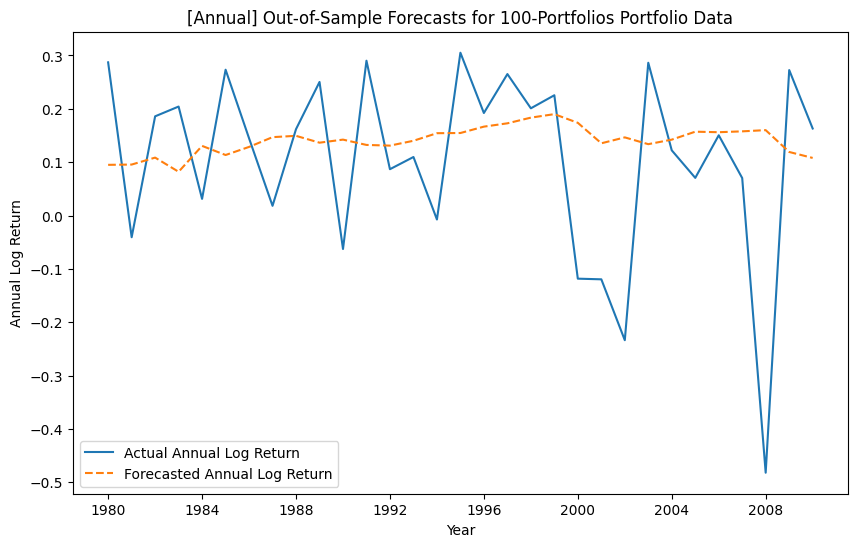

{'100-Portfolios': {'in_sample': {'phi': {'SMALL LoBM': -2.957737135259396,
    'ME1 BM2': 50.506838685478336,
    'ME1 BM3': -26.054706424077757,
    'ME1 BM4': 8.800453563242218,
    'ME1 BM5': 49.18631655679723,
    'ME1 BM6': 1.402925360225062,
    'ME1 BM7': 0.6583419982529023,
    'ME1 BM8': 0.8977917875018844,
    'ME1 BM9': 0.7127523926172252,
    'SMALL HiBM': 0.6489894363596465,
    'ME2 BM1': -40.4248136496663,
    'ME2 BM2': 32.00117314281092,
    'ME2 BM3': -16.13113395249032,
    'ME2 BM4': 0.5904107525798473,
    'ME2 BM5': 0.8272118380772188,
    'ME2 BM6': 0.732172720070185,
    'ME2 BM7': 0.7901291450171508,
    'ME2 BM8': 0.711439748539384,
    'ME2 BM9': 0.6043639855292356,
    'ME2 BM10': 0.6922848182033234,
    'ME3 BM1': 3.453836370881093,
    'ME3 BM2': -9.427332379386215,
    'ME3 BM3': -20.890426836768633,
    'ME3 BM4': 1.462022928594553,
    'ME3 BM5': 0.7483419024062503,
    'ME3 BM6': 0.7648156263037393,
    'ME3 BM7': 0.829355456688923,
    'ME3 BM8': 0.8

In [9]:
def regress_annual():
    portfolio_datasets = {
        # "6-Portfolios": "6_Portfolios_2x3",
        # "25-Portfolios": "25_Portfolios_5x5",
        "100-Portfolios": "100_Portfolios_10x10"
    }
    results = {}
    for label, dataset_name in portfolio_datasets.items():
        print(f"\n[Annual] Processing {label} Data")
        in_sample_results = regressions.run_in_sample_pls_annual(
            dataset_name=dataset_name,
            weighting="BE_FYt-1_to_ME_June_t",
            h=1,
            end_date='1980-01-01'
        )
        forecast_series, actual_series, R2_oos = regressions.run_recursive_forecast_annual(
            dataset_name=dataset_name,
            weighting="BE_FYt-1_to_ME_June_t",
            h=1,
            start_train_year=1930,
            end_train_year=1980,
            end_forecast_year=2010,
            n_components=1
        )
        regressions.display_results_annual(label, in_sample_results, forecast_series, actual_series, R2_oos)
        results[label] = {
            "in_sample": in_sample_results,
            "forecast_series": forecast_series,
            "actual_series": actual_series,
            "R2_oos": R2_oos
        }
    return results

regress_annual()